In [5]:
import requests
import re
import time
import pandas as pd 
import spacy
import os 
from bs4 import BeautifulSoup
from datetime import date

import matplotlib.pyplot as plt

from selenium import webdriver

nlp = spacy.load('en_core_web_sm', disable=['parser', 'lemmatizer', 'tagger'])


In [6]:
def clean_entities(ls):
    ls = [word.lower() for word in ls]
    ls = [re.sub(r'^the ', '', word) for word in ls]
    return ls

def count_words(clean_data):
    ngrams_dict = {}
    for ngram in clean_data:
        if ngram in ngrams_dict:
            ngrams_dict[ngram] += 1
        else:
            ngrams_dict[ngram] = 1
    return ngrams_dict


def time_stamp():
    today = date.today()
    d_today = today.strftime("%m-%d-%Y")

    return d_today

def barplot_entities(df, filter, source):
    df = df[df['entity_label'] == filter]
    df = df['entity_text'].tolist()
    df = clean_entities(df)
    df = count_words(df)
    df = pd.DataFrame(
    {'word': df.keys(), 'count': df.values() } )
    
    df = df[:25].copy()
    df.sort_values(by = ['count'], inplace = True, ascending = True)

    plt.barh(df['word'], df['count'])
    plt.ylabel(filter + ' Name')
    plt.title('Top ' + filter + 's Mentioned in ' + source + ' News Articles about Covid-19' )

    plt.rcParams["figure.figsize"] = [16,9]
    plt.show()

In [ ]:
#PERSON:      People, including fictional.
#NORP:        Nationalities or religious or political groups.
#FAC:         Buildings, airports, highways, bridges, etc.
#ORG:         Companies, agencies, institutions, etc.
#GPE:         Countries, cities, states.
#LOC:         Non-GPE locations, mountain ranges, bodies of water.
#PRODUCT:     Objects, vehicles, foods, etc. (Not services.)
#EVENT:       Named hurricanes, battles, wars, sports events, etc.
#WORK_OF_ART: Titles of books, songs, etc.
#LAW:         Named documents made into laws.
#LANGUAGE:    Any named language.
#DATE:        Absolute or relative dates or periods.
#TIME:        Times smaller than a day.
#PERCENT:     Percentage, including ”%“.
#MONEY:       Monetary values, including unit.
#QUANTITY:    Measurements, as of weight or distance.
#ORDINAL:     “first”, “second”, etc.
#CARDINAL:    Numerals that do not fall under another type.

In [7]:
keyword = re.compile(r'covid|coronavirus|vaccine|omicron|delta', re.IGNORECASE)
vaccines = re.compile(r'pfizer|moderna', re.IGNORECASE)

In [23]:
def scrape_pages(url, source):
    response = requests.get(url)
    start_page = BeautifulSoup(response.text, 'html.parser')
    
    scraped_pages = {}
    #article_id = 0
    out = {}

    for link in start_page.findAll('a'):
        try:
            page_url = link['href']

            if keyword.search(page_url):
                if not page_url in scraped_pages.keys():
                    #article_id = article_id + 1
                    # keep track of pages that have been scraped
                    scraped_pages[page_url] = source

                    next_page = requests.get(page_url)
                    page_content = BeautifulSoup(next_page.text, 'html.parser')

                    #paragraph_id = 0
                    for paragraph in page_content.findAll('p'):
                        paragraph = list(paragraph.stripped_strings)
                    
                        # each sentence is a list
                        for sentence in paragraph: 
                            sentence = nlp(sentence)

                            for entity in sentence.ents:
                                if not entity.label_ in out.keys():
                                    out[entity.label_] = [entity.text]
                                else:
                                    out[entity.label_].append(entity.text)

                    #next_page.nextfind_element_by_id('bt_gerar_cpf').click()

                            
                        # if I want to make a DF instead:
                        #paragraph_id = paragraph_id + 1
                        #out[str(article_id) + '~' + str(paragraph_id) + '~' + str(page_url) ] = list(paragraph.stripped_strings)
                
                    time.sleep(1)
   
        except:
            pass

    ts = time_stamp()

    cycle = 0
    if not os.path.exists('/home/stephbuon/projects/entascope/scraped_pages/' + ts):
        os.mkdir('/home/stephbuon/projects/entascope/scraped_pages/' + ts)

    citations = pd.DataFrame(
    {'url': scraped_pages.keys(), 'source': scraped_pages.values()} )

    citations.to_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'citations_' + source + '_' + ts + '.csv')

    named_entites = pd.DataFrame(
        {'entity_label': out.keys(), 'entity_text':out.values() } )
    named_entites = named_entites.explode('entity_text')

    for index, row in named_entites.iterrows():
        row['entity_label'] = 'EVENT' if (re.match(keyword, row['entity_text'])) else row['entity_label']
        row['entity_label'] = 'ORG' if (re.match(vaccines, row['entity_text'])) else row['entity_label']

    named_entites.to_csv('/home/stephbuon/projects/entascope/scraped_pages/' + ts + '/' + 'named_entities_' + source + '_' + ts + '.csv')

In [24]:
urls = ['https://www.npr.org/sections/news/', 'https://www.msnbc.com/', 'https://www.foxnews.com/']
sources = ['NPR', 'MSNBC', 'FOX']

for url in urls:
    for source in sources:
        scrape_pages(url, source)

FileNotFoundError: [Errno 2] No such file or directory: '/home/stephbuon/projects/entascope/scraped_pages/12-23-2021/citations_NPR_12-23-2021.csv'

In [11]:
#fox_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/named_entities_FOX_12-23-2021.csv')
msnbc_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/named_entities_MSNBC_12-23-2021.csv')
#npr_ne = pd.read_csv('/home/stephbuon/projects/entascope/scraped_pages/named_entities_NPR_12-23-2021.csv')

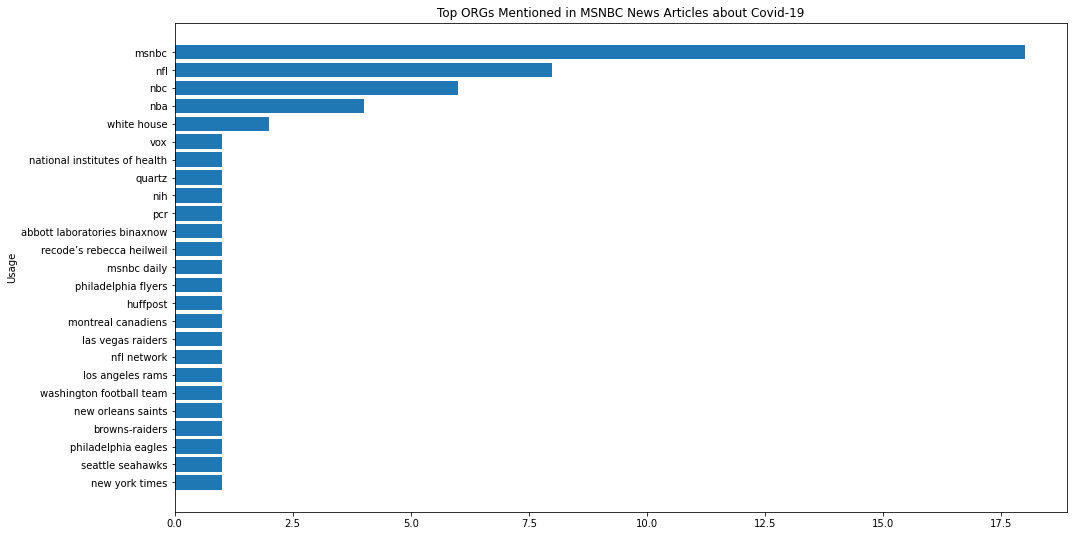

In [13]:
barplot_entities(msnbc_ne, 'ORG', source) # cut off the 's 

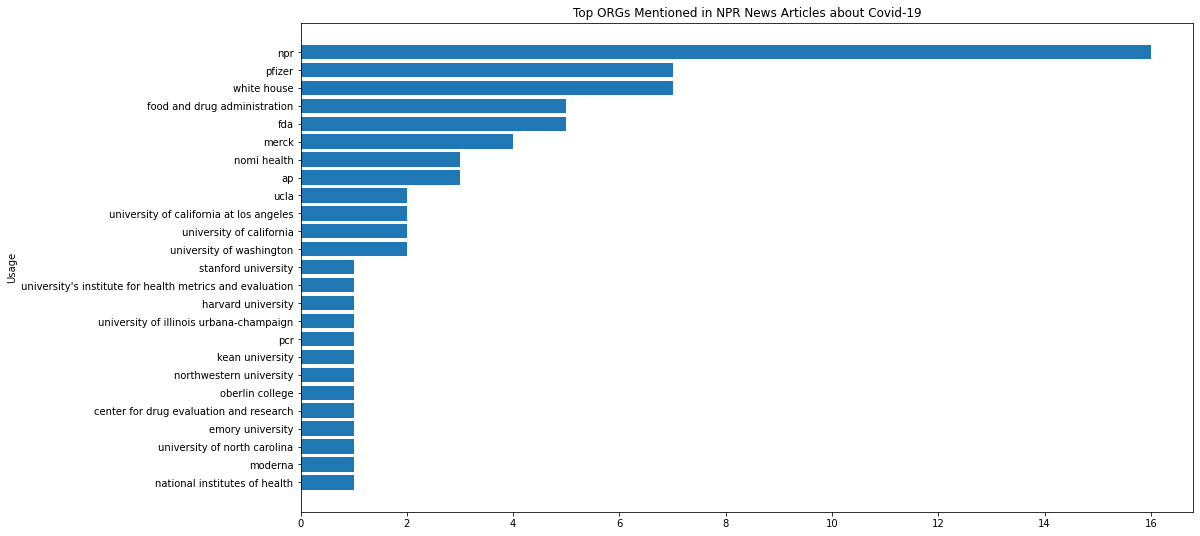

In [249]:
barplot_entities(npr_ne, 'ORG', source) # cut off the 's 

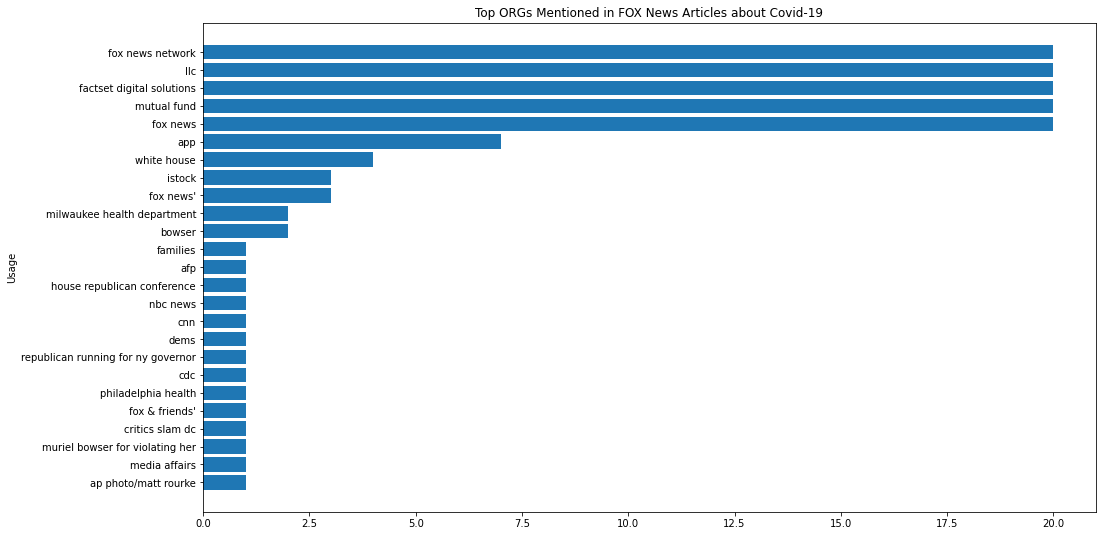

In [251]:
barplot_entities(fox_ne, 'ORG', 'FOX')

In [ ]:
from selenium import webdriver
options = webdriver.ChromeOptions()
options.binary_location = "/home/stephbuon/projects/entascope/chromedriver"
options.add_argument("--remote-debugging-port=9515")
chrome_driver_binary = '/home/stephbuon/projects/entascope/chromedriver'
driver = webdriver.Chrome(chrome_driver_binary, options = options)
driver.get('http://www.ubuntu.com/')



from selenium import webdriver
from time import sleep


def get_cpf():
    options = webdriver.ChromeOptions()
    options.add_argument('--no-sandbox')
    options.add_argument('--headless')
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument("--disable-setuid-sandbox") 
    options.add_argument("--remote-debugging-port=9222")
    options.add_argument("--disable-extensions") 
    options.add_argument("--disable-gpu") 
    options.add_argument("start-maximized") 
    options.add_argument("disable-infobars")

    options.binary_location = "/home/stephbuon/projects/entascope/chromedriver"

    chrome_driver_binary = "/home/stephbuon/projects/entascope/chromedriver"
    driver = webdriver.Chrome(chrome_driver_binary, chrome_options=options)
    #driver = webdriver.Chrome(executable_path='/home/stephbuon/projects/entascope/chromedriver')
    driver.get(url)
    driver.find_element_by_id('bt_gerar_cpf').click()
    sleep(10)
    text=driver.find_element_by_id('texto_cpf').text
    print(text)
get_cpf()


chromeOptions = webdriver.ChromeOptions() 
chromeOptions.add_experimental_option("prefs", {"profile.managed_default_content_settings.images": 2}) 
chromeOptions.add_argument("--no-sandbox") 
chromeOptions.add_argument("--disable-setuid-sandbox") 

chromeOptions.add_argument("--remote-debugging-port=9222")  # this

chromeOptions.add_argument("--disable-dev-shm-using") 
chromeOptions.add_argument("--disable-extensions") 
chromeOptions.add_argument("--disable-gpu") 
chromeOptions.add_argument("start-maximized") 
chromeOptions.add_argument("disable-infobars")
chromeOptions.add_argument(r"user-data-dir=.\cookies\\test") 

chrome_driver_binary = "/home/stephbuon/projects/entascope/chromedriver"

b = webdriver.Chrome(chrome_driver_binary, chrome_options=chromeOptions) 
b.get("https://google.com/") 
b.quit()